# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

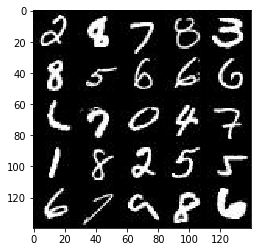

In [3]:
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

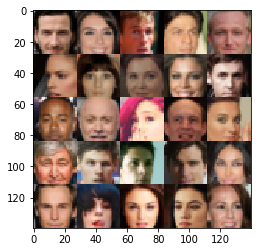

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Tensor of real input images
    input_real = tf.placeholder(
        dtype=tf.float32, 
        shape=(None, image_width, image_height, image_channels), 
        name='input_real')
    
    # Tensor of z data
    input_z = tf.placeholder(
        dtype=tf.float32,
        shape=(None, z_dim), 
        name='input_z')
    
    # Learning rate
    learning_rate = tf.placeholder(dtype=tf.float32)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
# 不可以指定卷积层与Batch Norm层的name，否则会报错：
# ValueError: Variable conv1/kernel already exists, disallowed. 
# Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope?
# 遗留问题。
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1
        conv1 = tf.layers.conv2d(
            inputs=images, 
            filters=64, 
            kernel_size=5, 
            strides=1,
            padding='same')
        
        lr1 = tf.nn.leaky_relu(features=conv1, name='lk1')
        
        # Layer 2
        conv2 = tf.layers.conv2d(
            inputs=lr1, 
            filters=128, 
            kernel_size=5, 
            strides=2, 
            padding='same')
        
        bn2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        
        lr2 = tf.nn.leaky_relu(features=bn2, name='lk2')
        
        # Layer 3
        conv3 = tf.layers.conv2d(
            inputs=lr2, 
            filters=256, 
            kernel_size=5, 
            strides=2, 
            padding='same')
        
        bn3 = tf.layers.batch_normalization(inputs=conv3, training=True)
        
        lr3 = tf.nn.leaky_relu(features=bn3, name='lk3')
        
        # Layer 4
        flatten = tf.layers.flatten(inputs=lr3, name='flatten')
        logits = tf.layers.dense(inputs=flatten, units=1)
        output = tf.nn.sigmoid(logits)

    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, reuse=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if is_train is False:
        reuse = True
        
    with tf.variable_scope('generator', reuse=reuse):
        # Layer 1
        dense1 = tf.layers.dense(inputs=z, units=4*4*512, activation=None)
        seeds = tf.reshape(tensor=dense1, shape=(-1, 4, 4, 512), name='seeds')
        bn1 = tf.layers.batch_normalization(inputs=seeds, training=is_train)
        lk1 = tf.nn.leaky_relu(bn1, name='lk1')
        # [4, 4, 512]
        
        # Layer 2
        conv2 = tf.layers.conv2d_transpose(inputs=lk1, filters=256, kernel_size=4, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(inputs=conv2, training=is_train)
        lk2 = tf.nn.leaky_relu(bn2, name='lk2')
        # [7, 7, 256]
        
        # Layer 3
        conv3 = tf.layers.conv2d_transpose(inputs=lk2, filters=128, kernel_size=3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(inputs=conv3, training=is_train)
        lk3 = tf.nn.leaky_relu(bn3, name='lk3')
        # [14, 14, 128]

        # Layer 4 -> [28, 28, 3]
        logits = tf.layers.conv2d_transpose(inputs=lk3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generate fake image with generator
    image_generated = generator(z= input_z, is_train=True, out_channel_dim=out_channel_dim)
    
    # Discriminator shows up.  Learn from real image..
    estimation_from_real, logtis_real = discriminator(images=input_real, reuse=False)
    # ..then the fake one.
    estimation_from_fake, logits_fake = discriminator(images=image_generated, reuse=True)
    
    loss_d_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logtis_real, labels=tf.ones_like(estimation_from_real)))
    
    loss_d_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_fake, labels=tf.zeros_like(estimation_from_fake)))
    
    loss_d = loss_d_real + loss_d_fake
    
    loss_g = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_fake, labels=tf.ones_like(estimation_from_fake)))
    
    return loss_d, loss_g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    var_d = tf.trainable_variables(scope='discriminator')
    var_g = tf.trainable_variables(scope='generator')
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_op_d = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=var_d)
        train_op_g = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=var_g)

    return train_op_d, train_op_g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(
        image_width=data_shape[1], 
        image_height=data_shape[2], 
        image_channels=data_shape[3], 
        z_dim=z_dim)
    
    loss_d, loss_g = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])

    train_op_d, train_op_g = model_opt(d_loss=loss_d, g_loss=loss_g, beta1=beta1, learning_rate=learning_rate)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(train_op_d, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(train_op_g, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = loss_d.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = loss_g.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Show generator output
                if steps % 100 == 0:
                    show_generator_output(
                        image_mode=data_image_mode, 
                        sess=sess, 
                        input_z=input_z, 
                        n_images=batch_size, 
                        out_channel_dim=data_shape[3])
                    
            print('Epoch {} Done!'.format(epoch_i + 1))
        
        show_generator_output(
            image_mode=data_image_mode, 
            sess=sess, 
            input_z=input_z, 
            n_images=batch_size, 
            out_channel_dim=data_shape[3])
        
        print("All done!")    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 9.0672... Generator Loss: 2.2469
Epoch 1/2... Discriminator Loss: 3.6248... Generator Loss: 12.2009
Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 12.4410
Epoch 1/2... Discriminator Loss: 6.8850... Generator Loss: 3.0173
Epoch 1/2... Discriminator Loss: 0.2209... Generator Loss: 7.1063
Epoch 1/2... Discriminator Loss: 0.0711... Generator Loss: 13.4099
Epoch 1/2... Discriminator Loss: 3.0907... Generator Loss: 1.4419
Epoch 1/2... Discriminator Loss: 0.5093... Generator Loss: 3.3178
Epoch 1/2... Discriminator Loss: 0.1827... Generator Loss: 3.9723
Epoch 1/2... Discriminator Loss: 0.2929... Generator Loss: 5.2193


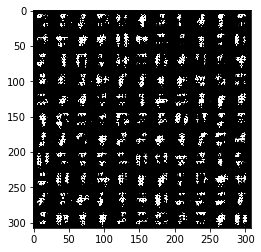

Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 6.8858
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 5.9854
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 1.7974
Epoch 1/2... Discriminator Loss: 1.7707... Generator Loss: 5.6311
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.9758
Epoch 1/2... Discriminator Loss: 4.5575... Generator Loss: 8.7185
Epoch 1/2... Discriminator Loss: 0.1732... Generator Loss: 3.0593
Epoch 1/2... Discriminator Loss: 5.1260... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 0.5034... Generator Loss: 2.8082


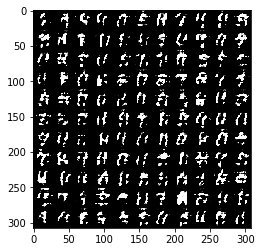

Epoch 1/2... Discriminator Loss: 1.8652... Generator Loss: 1.0516
Epoch 1/2... Discriminator Loss: 1.7417... Generator Loss: 6.4456
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 1.0398
Epoch 1/2... Discriminator Loss: 2.2262... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 2.8278
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.8233
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 1.3993
Epoch 1/2... Discriminator Loss: 1.7599... Generator Loss: 0.5554


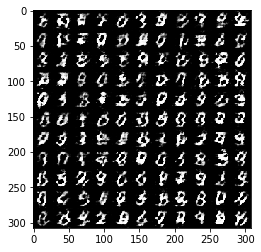

Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 1.9494
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 1.0608
Epoch 1/2... Discriminator Loss: 2.1458... Generator Loss: 4.1004
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 2.3558
Epoch 1/2... Discriminator Loss: 3.1138... Generator Loss: 5.5892
Epoch 1/2... Discriminator Loss: 0.8530... Generator Loss: 1.3213
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 2.0772
Epoch 1/2... Discriminator Loss: 3.7526... Generator Loss: 5.7790
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 1.4725... Generator Loss: 0.5271


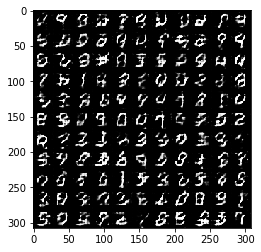

Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 2.2491... Generator Loss: 0.2664
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 1.8809... Generator Loss: 0.2465
Epoch 1/2... Discriminator Loss: 1.9225... Generator Loss: 3.3346
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 0.7761
Epoch 1 Done!
Epoch 2/2... Discriminator Loss: 1.6731... Generator Loss: 0.4799
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 1.8119
Epoch 2/2... Discriminator Loss: 0.9645... Generator Loss: 1.4200
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.5194


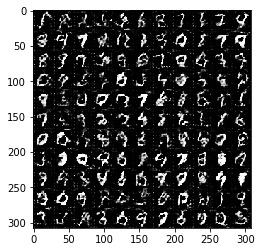

Epoch 2/2... Discriminator Loss: 1.8195... Generator Loss: 3.5207
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 1.6025
Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 1.4730
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 1.9579
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 3.3810... Generator Loss: 4.9527
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 1.1713
Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 2.2534... Generator Loss: 0.2303


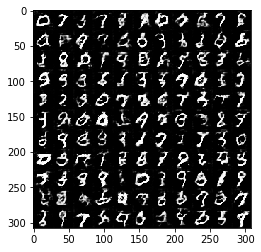

Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 1.2552
Epoch 2/2... Discriminator Loss: 1.5677... Generator Loss: 0.4640
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 2.2720
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.5522
Epoch 2/2... Discriminator Loss: 1.6131... Generator Loss: 2.2957
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 1.2407


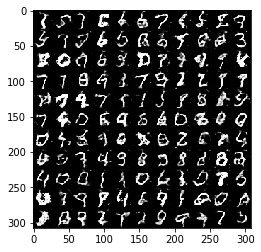

Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 1.9207
Epoch 2/2... Discriminator Loss: 1.2374... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 2.9480... Generator Loss: 0.1111
Epoch 2/2... Discriminator Loss: 1.1418... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 1.0195
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 0.4464
Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 1.3847


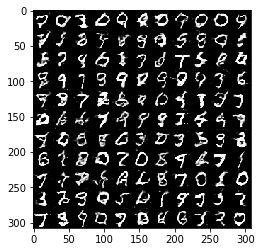

Epoch 2/2... Discriminator Loss: 1.4979... Generator Loss: 0.3869
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 0.8601
Epoch 2/2... Discriminator Loss: 1.8085... Generator Loss: 2.3705
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.9835
Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 1.8029
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 1.8844
Epoch 2/2... Discriminator Loss: 2.0187... Generator Loss: 0.2256
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 1.4385
Epoch 2/2... Discriminator Loss: 1.0738... Generator Loss: 0.6988


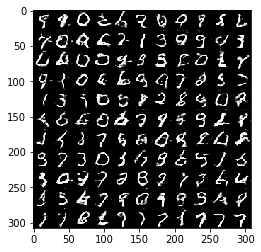

Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 1.1242
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 1.3792
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 0.7648
Epoch 2 Done!


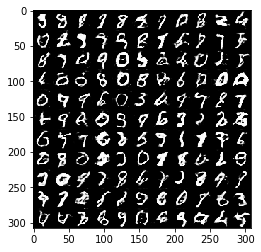

All done!


In [24]:
batch_size = 128
z_dim = 128
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 15.1218
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 2.5447
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 5.0077
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 3.2487
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 2.5820
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 6.1818
Epoch 1/1... Discriminator Loss: 0.0562... Generator Loss: 5.1843
Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 5.8944
Epoch 1/1... Discriminator Loss: 0.0836... Generator Loss: 4.9386


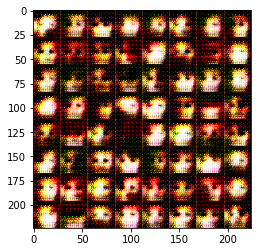

Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 2.4255
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 2.2288
Epoch 1/1... Discriminator Loss: 0.0493... Generator Loss: 3.5584
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 10.5925
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 8.0343
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 1.7304
Epoch 1/1... Discriminator Loss: 3.2599... Generator Loss: 18.0856
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 2.7488
Epoch 1/1... Discriminator Loss: 0.1830... Generator Loss: 3.7932


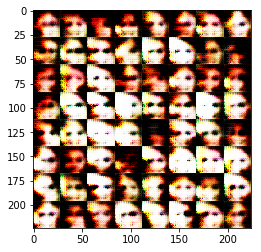

Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 3.9844
Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 2.3635
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 6.7160
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 5.8538
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 6.9146
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 9.0113
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 4.6967
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 5.5825
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 5.1248
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 6.2088


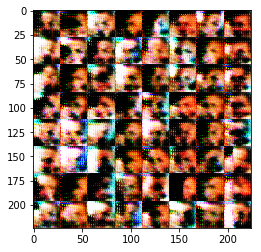

Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 8.7191
Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 3.1717
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 5.3429
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 4.2870
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 5.1024
Epoch 1/1... Discriminator Loss: 0.0046... Generator Loss: 7.8430
Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 7.0081
Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 6.3988
Epoch 1/1... Discriminator Loss: 0.3149... Generator Loss: 5.0406


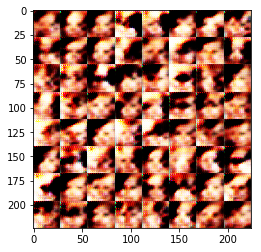

Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.8525
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 3.0575
Epoch 1/1... Discriminator Loss: 0.3149... Generator Loss: 2.7934
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.3901
Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 2.4929
Epoch 1/1... Discriminator Loss: 2.4040... Generator Loss: 0.1890


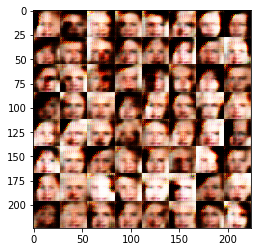

Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 2.8224
Epoch 1/1... Discriminator Loss: 0.0132... Generator Loss: 6.5055
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 3.2997
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 10.2622
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 6.0325
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 9.2511
Epoch 1/1... Discriminator Loss: 0.0468... Generator Loss: 8.9389
Epoch 1/1... Discriminator Loss: 0.0568... Generator Loss: 4.3621
Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 7.4092


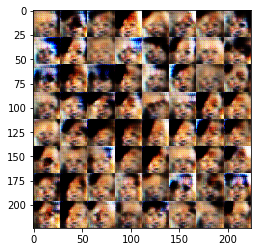

Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 8.7780
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 4.2446
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 2.5928
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.2891
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 2.9351
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 3.1333
Epoch 1/1... Discriminator Loss: 0.2673... Generator Loss: 4.1333
Epoch 1/1... Discriminator Loss: 0.1424... Generator Loss: 6.3668
Epoch 1/1... Discriminator Loss: 2.8197... Generator Loss: 9.0147
Epoch 1/1... Discriminator Loss: 2.1405... Generator Loss: 5.3213


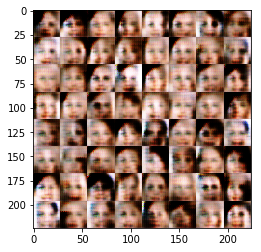

Epoch 1/1... Discriminator Loss: 4.0820... Generator Loss: 9.4898
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 4.4746
Epoch 1/1... Discriminator Loss: 0.2885... Generator Loss: 2.2148
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 5.8416
Epoch 1/1... Discriminator Loss: 0.2741... Generator Loss: 2.2312
Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 5.9541
Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 5.9097
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 5.7789
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 6.3896
Epoch 1/1... Discriminator Loss: 0.0472... Generator Loss: 6.8784


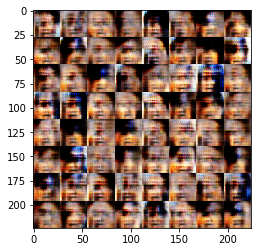

Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 4.9503
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 5.7504
Epoch 1/1... Discriminator Loss: 0.0671... Generator Loss: 3.5374
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 7.2114
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 10.4366
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 7.2563
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 11.4295
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 2.3843
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 12.1313
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 6.8059


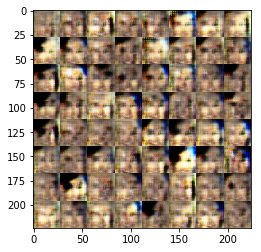

Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 10.6483
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 10.8535
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 12.6353
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 7.5669
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 8.8731
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 3.3390
Epoch 1/1... Discriminator Loss: 2.5668... Generator Loss: 9.2266
Epoch 1/1... Discriminator Loss: 0.2540... Generator Loss: 2.7751
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 3.2840
Epoch 1/1... Discriminator Loss: 1.6565... Generator Loss: 9.3046


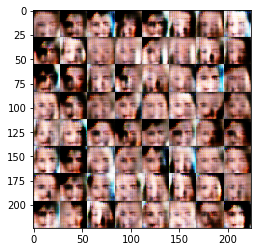

Epoch 1/1... Discriminator Loss: 0.0464... Generator Loss: 7.6622
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 6.8010
Epoch 1/1... Discriminator Loss: 9.1641... Generator Loss: 14.1469
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 2.2315
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 2.6171
Epoch 1/1... Discriminator Loss: 0.3080... Generator Loss: 2.5870
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 1.7022
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 0.2092... Generator Loss: 3.4790
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 5.0001


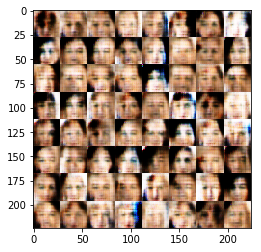

Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 5.4656
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 3.0720
Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 6.1068
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 9.6481
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 6.2666
Epoch 1/1... Discriminator Loss: 0.0677... Generator Loss: 6.0066
Epoch 1/1... Discriminator Loss: 0.0904... Generator Loss: 9.9114
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 4.9435
Epoch 1/1... Discriminator Loss: 3.0255... Generator Loss: 0.1429


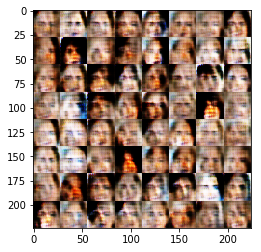

Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 0.1869... Generator Loss: 6.5012
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 4.6850... Generator Loss: 8.6655
Epoch 1/1... Discriminator Loss: 0.0752... Generator Loss: 4.1135
Epoch 1/1... Discriminator Loss: 0.1265... Generator Loss: 3.3277
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 4.0702
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 6.8226
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 0.1176... Generator Loss: 7.3993


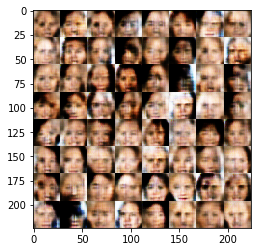

Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 6.0721... Generator Loss: 13.1687
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 4.6310
Epoch 1/1... Discriminator Loss: 0.1527... Generator Loss: 6.1454
Epoch 1/1... Discriminator Loss: 0.2027... Generator Loss: 2.8353
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 7.7873
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 3.6469
Epoch 1/1... Discriminator Loss: 0.0225... Generator Loss: 7.0755
Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.3470
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 9.3398


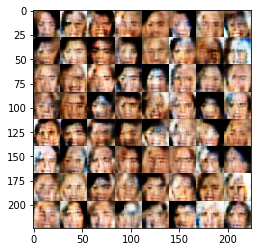

Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 4.7954
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 6.9720
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 5.8432
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 7.5800
Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 10.1645
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 5.5033
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 7.8513
Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 6.6275
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 9.7401
Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 5.0562


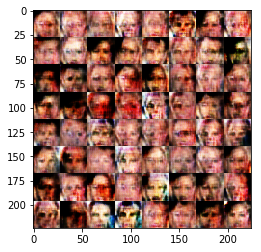

Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 11.8694
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 6.1104
Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 9.7315
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 8.4951
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 6.1114
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 3.1036
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 2.5702... Generator Loss: 0.2364
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 2.6389
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 5.3514


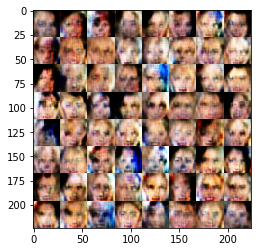

Epoch 1/1... Discriminator Loss: 4.5690... Generator Loss: 9.8319
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.7607... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 6.9849
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.2074... Generator Loss: 3.3413
Epoch 1/1... Discriminator Loss: 0.1024... Generator Loss: 9.5632
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 4.5521
Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 4.6555
Epoch 1/1... Discriminator Loss: 0.0276... Generator Loss: 5.9034


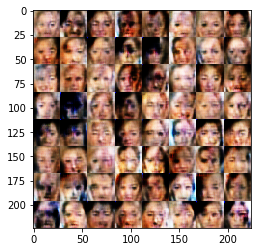

Epoch 1/1... Discriminator Loss: 0.1994... Generator Loss: 3.5735
Epoch 1/1... Discriminator Loss: 0.0424... Generator Loss: 5.1692
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 2.9354
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 7.3975
Epoch 1/1... Discriminator Loss: 0.0374... Generator Loss: 5.6108
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 3.9143
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 1.9230
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 5.5884


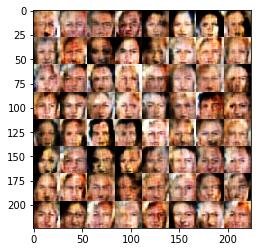

Epoch 1/1... Discriminator Loss: 0.1196... Generator Loss: 3.6217
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 10.8498
Epoch 1/1... Discriminator Loss: 0.0404... Generator Loss: 4.7584
Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.3617
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 9.1022
Epoch 1/1... Discriminator Loss: 1.9607... Generator Loss: 13.3863
Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 9.4473
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.3045
Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 3.8392


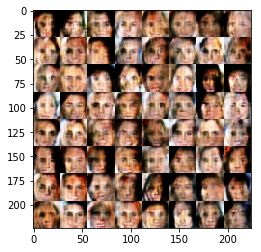

Epoch 1/1... Discriminator Loss: 0.1247... Generator Loss: 9.1398
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 9.1111
Epoch 1/1... Discriminator Loss: 1.8894... Generator Loss: 0.4668
Epoch 1/1... Discriminator Loss: 0.0327... Generator Loss: 6.1090
Epoch 1/1... Discriminator Loss: 0.0762... Generator Loss: 4.1144
Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 8.5936
Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 5.2464
Epoch 1/1... Discriminator Loss: 2.9184... Generator Loss: 0.1292
Epoch 1/1... Discriminator Loss: 0.0277... Generator Loss: 5.9458


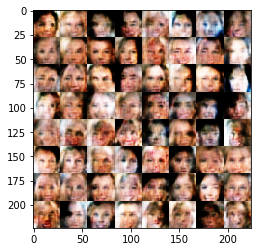

Epoch 1/1... Discriminator Loss: 0.1579... Generator Loss: 11.7064
Epoch 1/1... Discriminator Loss: 0.1055... Generator Loss: 3.8194
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 7.7861
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 4.5332
Epoch 1/1... Discriminator Loss: 0.1285... Generator Loss: 5.3761
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 0.0884... Generator Loss: 4.0460
Epoch 1/1... Discriminator Loss: 0.0462... Generator Loss: 4.6561
Epoch 1/1... Discriminator Loss: 0.0413... Generator Loss: 4.9710
Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 5.6664


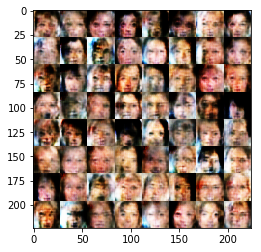

Epoch 1/1... Discriminator Loss: 0.0437... Generator Loss: 9.1825
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 14.5086
Epoch 1/1... Discriminator Loss: 0.1569... Generator Loss: 3.0809
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 9.2190
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 14.0109
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 11.4014
Epoch 1/1... Discriminator Loss: 0.0909... Generator Loss: 3.8750
Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 4.0337
Epoch 1/1... Discriminator Loss: 0.0550... Generator Loss: 10.5458
Epoch 1/1... Discriminator Loss: 0.0266... Generator Loss: 5.3544


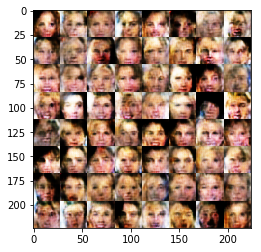

Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 7.5376
Epoch 1/1... Discriminator Loss: 4.9166... Generator Loss: 13.9289
Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 4.7464
Epoch 1/1... Discriminator Loss: 0.1447... Generator Loss: 3.8810
Epoch 1/1... Discriminator Loss: 0.1427... Generator Loss: 4.6440
Epoch 1/1... Discriminator Loss: 0.1170... Generator Loss: 4.4895
Epoch 1/1... Discriminator Loss: 0.0908... Generator Loss: 5.1645
Epoch 1/1... Discriminator Loss: 0.0349... Generator Loss: 9.3038
Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 5.7170
Epoch 1/1... Discriminator Loss: 0.0755... Generator Loss: 4.0449


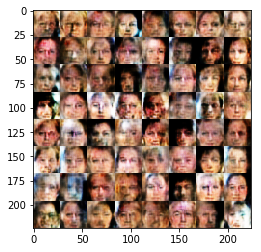

Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 10.9522
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 1.6945
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 7.6282
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 5.1421
Epoch 1/1... Discriminator Loss: 0.1421... Generator Loss: 3.6701
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 7.0493
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 4.5725
Epoch 1/1... Discriminator Loss: 0.0523... Generator Loss: 5.2378
Epoch 1/1... Discriminator Loss: 0.2008... Generator Loss: 2.7864
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 1.4793


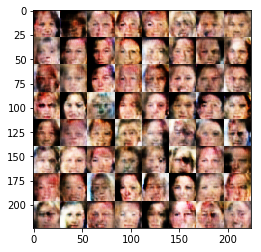

Epoch 1/1... Discriminator Loss: 0.0613... Generator Loss: 7.9366
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 8.2968
Epoch 1/1... Discriminator Loss: 0.0963... Generator Loss: 7.0725
Epoch 1/1... Discriminator Loss: 0.0102... Generator Loss: 6.9841
Epoch 1/1... Discriminator Loss: 0.0886... Generator Loss: 4.6759
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 7.8829
Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 8.8965
Epoch 1/1... Discriminator Loss: 0.0463... Generator Loss: 4.3778
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 7.3291


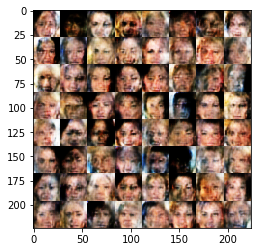

Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 6.1650
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 0.1125... Generator Loss: 6.9151
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 6.9785
Epoch 1/1... Discriminator Loss: 0.0869... Generator Loss: 3.7989
Epoch 1/1... Discriminator Loss: 0.0569... Generator Loss: 10.4498
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 10.1796
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 2.8820


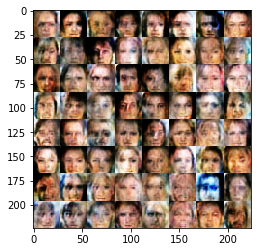

Epoch 1/1... Discriminator Loss: 5.9511... Generator Loss: 0.0361
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 4.2300
Epoch 1/1... Discriminator Loss: 0.1999... Generator Loss: 4.1235
Epoch 1/1... Discriminator Loss: 0.1319... Generator Loss: 4.0941
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 5.1195
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 7.4829
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 1.9940
Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.0121
Epoch 1/1... Discriminator Loss: 1.8358... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 3.2068


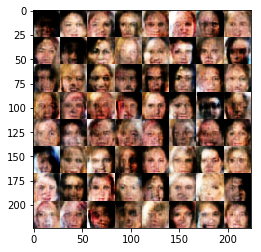

Epoch 1/1... Discriminator Loss: 0.2156... Generator Loss: 10.6773
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 7.5669
Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 4.8524
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.8487... Generator Loss: 10.1130
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 2.7239
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 0.0424... Generator Loss: 8.9941
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 4.4472
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 2.9815


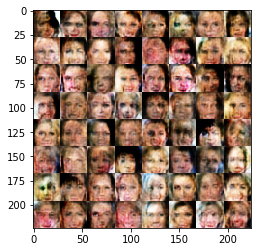

Epoch 1/1... Discriminator Loss: 2.1224... Generator Loss: 9.2021
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 7.3852
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 2.9768
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 10.5704
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 4.2032
Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 5.0726
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 6.8990
Epoch 1/1... Discriminator Loss: 0.0042... Generator Loss: 9.2260
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 11.3112
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 6.6783


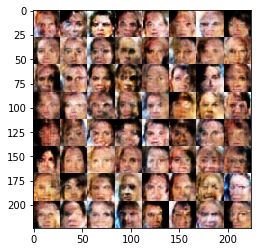

Epoch 1/1... Discriminator Loss: 0.0883... Generator Loss: 7.3832
Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 2.4716
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.7483
Epoch 1/1... Discriminator Loss: 0.0496... Generator Loss: 5.1888
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 6.0043
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 0.2039... Generator Loss: 3.3678
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 11.1696
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 7.1487


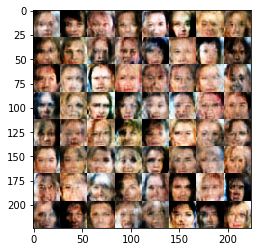

Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 11.7928
Epoch 1/1... Discriminator Loss: 2.2233... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 0.1536... Generator Loss: 3.0150
Epoch 1/1... Discriminator Loss: 0.1284... Generator Loss: 3.7807
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 2.6801
Epoch 1/1... Discriminator Loss: 0.0292... Generator Loss: 6.6239
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 11.5938
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 7.8382
Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 6.9394
Epoch 1/1... Discriminator Loss: 0.0422... Generator Loss: 5.9038


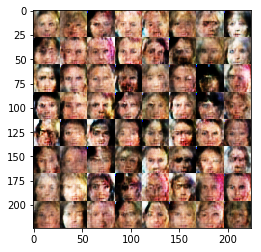

Epoch 1/1... Discriminator Loss: 4.4465... Generator Loss: 13.8011
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 5.6646
Epoch 1/1... Discriminator Loss: 0.2888... Generator Loss: 2.3250
Epoch 1/1... Discriminator Loss: 0.2308... Generator Loss: 2.9095
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 7.4407
Epoch 1/1... Discriminator Loss: 0.1543... Generator Loss: 3.6397
Epoch 1 Done!


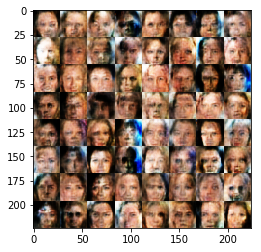

All done!


In [29]:
batch_size = 64
z_dim = 256
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.